In [1]:
import polars as pl
import numpy as np
from typing import List

def lag_exprs(col: str, lag: int) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, window: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    EPSILON = 1e-5
    return ((pl.col(col).abs() + EPSILON).log1p() - (pl.col(col).abs() + EPSILON).shift(window).log1p()).alias(f"{col}_momentum_ratio_{window}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window, min_samples=1).alias(f"{col}_volatility_{window}")

def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and not col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lags: [int],
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            momentum_ratio_expr(col, window),
            rolling_volatility_expr(col, window),
        ])
        for lag in lags:
            single_exprs.extend([
            lag_exprs(col, lag),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
        ])
            
    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lags: [int],
        log1p_cols: List[str] = None,
        exclude_cols: List[str] = None,
) -> pl.DataFrame:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']
        
    if log1p_cols is None:
        log1p_cols = []

    for col in log1p_cols:
        if col in df_to_transforms.columns:
            df_to_transforms = df_to_transforms.with_columns([
                pl.col(col).clip(lower_bound=0.0).log1p().alias(col)
            ])
            
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lags, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)
    # return df_to_transforms



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_month(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = origin_input_df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        origin_input_df.filter(pl.col("month_start") == mt).drop("month_start")
        for mt in unique_months["month_start"]
    ]

    return monthly_dfs

    
def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        # .rolling_mean(window, min_samples=1)
        .tanh()
        # .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_tanh_normalize(
    rollin_df: pl.DataFrame,
    window: int,
    rolling_mean_window: int,
) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_tanh_expr(
            col=column,
            scaled_col=f"{column}_zscaled",
            window=window,
            rolling_mean_window=rolling_mean_window,
        ) for column in columns_to_normalize
    ]) 

def z_score_tanh_expr(
    col: str,
    scaled_col: str,
    window: int,
    rolling_mean_window: int,
) -> pl.Expr:
    EPSILON = 1e-6
    mean_expr = pl.col(col).rolling_mean(window, min_samples=1)
    std_expr = pl.col(col).rolling_std(window, min_samples=1).fill_nan(0)

    return (
        ((pl.col(col) - mean_expr) / (std_expr + EPSILON))
        .fill_nan(0)
        .fill_null(0)
        .clip(-3.0, 3.0)
        .tanh()
        .rolling_mean(rolling_mean_window, min_samples=1)
        .alias(scaled_col)
    )


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
def process_single_symbol(
    symbol: str,
    threshold: str = "0.002",
    feat_cal_window: str = "500",
    data_dir: str = "C:/quant/data/binance_resampled_data/",
    feat_trans_window: int = 350,
    feat_trans_lags: list[int] = [5, 10, 20, 50, 100, 150, 200],
    feat_norm_window: int = 500,
    feat_norm_rolling_mean_window: int = 10,
) -> pl.DataFrame:
    file = f"{symbol}_factors_threshold{threshold}_rolling{feat_cal_window}.csv"
    path = data_dir + file
    df = pl.read_csv(path)

    # 删掉不需要的列
    df = df.drop([
        "top_acc_longShortRatio", "top_pos_longShortRatio", "acc_longShortRatio"
    ])

    # 对部分列进行 log1p + lag 变换
    cols_to_log1p = [
        "far_bid_price", "far_ask_price",
        "best_bid_price", "best_ask_price",
        "sum_buy_sz", "sum_sell_sz",
        "ts_duration", "real_bid_amount_sum", "real_ask_amount_sum",
    ]
    df = batch_apply_transforms(df, feat_trans_window, feat_trans_lags, cols_to_log1p)

    # rolling z-score + tanh 归一
    df = rolling_z_tanh_normalize(df, feat_norm_window, feat_norm_rolling_mean_window)

    # 去掉 std=0 的列
    stds = df.select([
        pl.col(col).std().alias(col)
        for col in df.columns
        if df[col].dtype in (pl.Float64, pl.Int64)
    ])
    zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
    df = df.drop(zero_std_cols)

    return df


In [4]:
symbol = "solusdt"
symbol.upper()
threshold = "0.002"
feat_cal_window = "500"
file = symbol + "_factors_threshold" + threshold + "_rolling" + feat_cal_window + ".csv"
path = "C:/quant/data/binance_resampled_data/" + file
origin_df = pl.read_csv(path)
origin_df = origin_df.drop(["top_acc_longShortRatio", "top_pos_longShortRatio", "acc_longShortRatio"])
cols_to_log1p = [
    "far_bid_price",
    "far_ask_price",
    "best_bid_price",
    "best_ask_price",
    "sum_buy_sz",
    "sum_sell_sz",
    "ts_duration",
    "real_bid_amount_sum",
    "real_ask_amount_sum",
]
feat_trans_window = 500
feat_trans_lags = [5, 10, 20, 50, 100, 150, 200]
feat_norm_window = 500
feat_norm_rolling_mean_window = 500
print(origin_df)
origin_df = batch_apply_transforms(origin_df, feat_trans_window, feat_trans_lags, cols_to_log1p)
origin_df = rolling_z_tanh_normalize(origin_df, feat_norm_window, feat_norm_rolling_mean_window)
print(origin_df)
stds = origin_df.select([
    pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
])
zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
print(zero_std_cols)
origin_df = origin_df.drop(zero_std_cols)
print(origin_df)


shape: (43_950, 109)
┌───────────────┬────────┬────────────┬─────────────┬───┬──────────────────────┬──────────────────────┬─────────────────────┬─────────────────────┐
│ timestamp     ┆ px     ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_tr ┆ z_factor_order_senti ┆ z_factor_oi_momentu ┆ z_factor_oi_momentu │
│ ---           ┆ ---    ┆ ---        ┆ ---         ┆   ┆ end_confir…          ┆ ment_diver…          ┆ m_punch             ┆ m_long_term…        │
│ i64           ┆ f64    ┆ f64        ┆ f64         ┆   ┆ ---                  ┆ ---                  ┆ ---                 ┆ ---                 │
│               ┆        ┆            ┆             ┆   ┆ f64                  ┆ f64                  ┆ f64                 ┆ f64                 │
╞═══════════════╪════════╪════════════╪═════════════╪═══╪══════════════════════╪══════════════════════╪═════════════════════╪═════════════════════╡
│ 1743984079416 ┆ 106.06 ┆ 39316.0    ┆ 24285.0     ┆ … ┆ 0.0                  ┆ 0.0       

In [5]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# pdf = origin_df.to_pandas()
# # pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], unit="ms")

# # 计算百分比变化（return）
# pdf["px_pct"] = pdf["px"].pct_change()

# # 绘图
# plt.figure(figsize=(8, 4))
# plt.hist(pdf["px_pct"].dropna() * 100, bins=50, color="orange", edgecolor="k")
# plt.title("Distribution of Percentage Price Change (px.pct_change())")
# plt.xlabel("Price Change (%)")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_last_n_rows_with_px_regression(
    y_true,           # 真实未来收益率
    y_pred,           # 模型预测收益率
    px,               # 价格
    std_array=None,   # 可选标准差
    n=700,
    m=-1,
    alpha=1.0
):
    # 截取最近 n 行
    y_true_slice = y_true[n:m]
    y_pred_slice = y_pred[n:m]
    px_slice = px[n:m]
    std_slice = std_array[n:m] if std_array is not None else None

    time_index = np.arange(len(y_true_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 价格线
    ax1.plot(time_index, px_slice, color='tab:gray', label='Price (px)', linewidth=1.5)
    if std_slice is not None:
        ax1.plot(time_index, px_slice + alpha * std_slice, linestyle=':', color='gray', alpha=0.4, label='+std')
        ax1.plot(time_index, px_slice - alpha * std_slice, linestyle=':', color='gray', alpha=0.4, label='-std')

    ax1.set_ylabel("Price")
    ax1.set_xlabel("Time Index")
    ax1.tick_params(axis='y', labelcolor='black')

    # 创建第二个 y 轴：收益率
    ax2 = ax1.twinx()
    ax2.plot(time_index, y_true_slice, label='True Future Return', color='tab:blue', linewidth=1.5)
    ax2.plot(time_index, y_pred_slice, label='Predicted Return', color='tab:green', linestyle='--', linewidth=1.5)
    ax2.set_ylabel("Return")
    ax2.tick_params(axis='y', labelcolor='black')

    # 图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f"Price, True Return, and Predicted Return (Last {n} rows)")
    plt.tight_layout()
    plt.show()


<!-- ## import polars as pl
import numpy as np
from tqdm import tqdm
z
rolling_window = 150
alpha = 2

a_df = (
    origin_df
    .with_columns([
        pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
    ])
)

def label_by_future_std(px: np.ndarray, std: np.ndarray) -> np.ndarray:
    n = len(px)
    labels = np.full(n, -1)  # 初始化为 -1（未触发）

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]
            if px[j] >= upper_bound:
                labels[i] = 1
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                break

            else:
                labels[i] = -1
 
    return labels

px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()

labels_np = label_by_future_std(px_np, std_np)

a_df = a_df.with_columns(pl.Series("future_std_label", labels_np))
print(a_df)
a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs: ", len(weekly_dataframes)) -->

In [9]:
import polars as pl
import numpy as np
from tqdm import tqdm

future_window = 150 # 改成预测未来150步的收益率

# 假设你已经有了 origin_df
px_np = origin_df["px"].to_numpy()

def future_return(px: np.ndarray, window: int, use_log_return: bool = False) -> np.ndarray:
    n = len(px)
    returns = np.full(n, np.nan)

    for i in tqdm(range(n - window), desc="Calculating future returns"):
        if use_log_return:
            returns[i] = np.log(px[i + window] / px[i]) if px[i] > 0 else np.nan
        else:
            returns[i] = (px[i + window] - px[i]) / px[i] if px[i] > 0 else np.nan

    return returns

# 计算未来收益率标签
future_return_label = future_return(px_np, future_window, use_log_return=True)

# 加入 DataFrame
a_df = origin_df.with_columns([
    pl.Series("future_return", future_return_label)
])

# 去除 NaN
a_df_filtered = a_df.filter(pl.col("future_return").is_not_null())
a_df_filtered = clean_df_drop_nulls(a_df_filtered)

# 可选：按周分割
weekly_dataframes = split_df_by_month(a_df_filtered)
print("num weekly dfs: ", len(weekly_dataframes))


Calculating future returns: 100%|██████████████████████████████████████████████████████████████████████| 43800/43800 [00:00<00:00, 1460140.64it/s]


各列空值数量：
sum_buy_sz_momentum_ratio_500                               500
sum_buy_sz_volatility_500                                     1
sum_buy_sz_lag_5                                              5
sum_buy_sz_diff_5                                             5
sum_buy_sz_second_order_diff_5                               10
                                                           ... 
factor_oi_momentum_long_term_punch_second_order_diff_150    300
factor_oi_momentum_long_term_punch_lag_200                  200
factor_oi_momentum_long_term_punch_diff_200                 200
factor_oi_momentum_long_term_punch_second_order_diff_200    400
future_return                                               150
Length: 1450, dtype: int64
删除空值超过 10000 的列：[]
删除列后，DataFrame形状：(43950, 7021)
空值最多的列是：sum_buy_sz_momentum_ratio_500，共有 500 个空值
删除空值行后，DataFrame形状：(43300, 7021)
num weekly dfs:  5


In [10]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


In [11]:
n_train_weeks = 3 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = "future_return"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_zscaled") 
        # and (col.startswith("z_")) 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# print(feature_cols)
print(len(feature_cols))
# feature_cols = ["z_oi_di"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

overall_start = None
overall_end = None


for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])

    fold_start = train_df['timestamp_dt'][0]
    fold_end = val_df['timestamp_dt'][-1]

    # 更新 overall_start 和 overall_end
    if overall_start is None or fold_start < overall_start:
        overall_start = fold_start
    if overall_end is None or fold_end > overall_end:
        overall_end = fold_end
        
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8

    # sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # # # #LGBM
    # lgb_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.001, max_depth=4, verbose=-1)
    # early_stopping_callback = lgb.early_stopping(
    #     stopping_rounds=500,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
    #     verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
    # )
    # lgb_model.fit(
    #     X_train, y_train,
    #     sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #     eval_set=[(X_val, y_val)],
    #     eval_metric='acc',
    #     # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    # )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(lgb_model.predict_proba(X_test)[:, 1], y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
    # lgb_test_pred_probs = lgb_model.predict_proba(X_test)[:, 1]

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': lgb_test_pred_probs,
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_lgb_test_predictions.append(current_window_results)

    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    params = {
        # 模型结构参数
        "n_d": 8,                      # 决策输出维度
        "n_a": 8,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared":2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": [],               # 类别特征的列索引
        "cat_dims": [],               # 每个类别特征的类别数
        "cat_emb_dim": 1,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-5,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "sparsemax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 1e-2},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 20,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "max_epochs": 200,
        "patience": 75,
        "batch_size": 2048,
        "virtual_batch_size": 512,
    }

    inc_fit_params = {
        "max_epochs": 50,
        "patience": 10,
        "batch_size": 1024,
        "virtual_batch_size": 256,
        "warm_start": True,
    }

    # # Label Encode y（如果是0/1就不用）
    # y_train_enc = y_train.astype(int)
    # y_val_enc = y_val.astype(int)
    
    # sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)
    # print(sample_weights)
    
    # TabNet 训练
    
    # tabnet = TabNetClassifier(**params)
    # tabnet.fit(
    #     X_train=X_train.values, y_train=y_train_enc,
    #     eval_set=[(X_val.values, y_val_enc)],
    #     weights=sample_weights,
    #     **init_fit_params,
    # )

    # # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
    
    # tabnet_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
    #     model_name="tabnet",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    # tabnet_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
    #     model_name="tabnet",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )

    # plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "TST", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': tabnet.predict_proba(X_test.values)[:, 1],
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_tabnet_test_predictions.append(current_window_results)

    # TabNet_incremental 训练
    tabnet = TabNetRegressor(**params)
    tabnet.fit(
        X_train=X_train.values, 
        y_train=y_train.values.reshape(-1, 1),
        **init_fit_params,
    )

    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    y_val_pred = tabnet.predict(X_val.values)
    print("回归评估 (Val):")
    print("MSE:", mean_squared_error(y_val, y_val_pred))
    print("MAE:", mean_absolute_error(y_val, y_val_pred))
    print("R²:", r2_score(y_val, y_val_pred))
    
    # 可选：定义置信区间（过滤极端预测）
    conf_thresh = 0.005  # 例如：只看预测收益率 > 0.5% 或 < -0.5%
    mask = (np.abs(y_val_pred) >= conf_thresh)
    print("过滤高置信度样本数量: ", mask.sum())

    # 收集预测结果（Val 可选，Test 常用于回测）
    current_window_results = pd.DataFrame({
        'timestamp': timestamps_val,  # 注意：用 test 数据
        'symbol': symbol,
        'true_label': y_val,
        'predicted_value': y_val_pred.ravel(),  # 保证是一维
        'px': px_val,
    })
    
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'val_period': f"{val_df['timestamp_dt'][0]} to {val_df['timestamp_dt'][-1]}",
        # 'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        # 'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")
 
# 存储该周评估信息
week_results = {
    'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
    'val_period': f"{val_df['timestamp_dt'][0]} to {val_df['timestamp_dt'][-1]}",
    'TabNet_MSE': mean_squared_error(y_val, y_val_pred),
    'TabNet_MAE': mean_absolute_error(y_val, y_val_pred),
    'TabNet_R2': r2_score(y_val, y_val_pred),
    'HighConfidenceCount': int(mask.sum())
}
results.append(week_results)

print(f"Test Week {i + n_train_weeks} Evaluation Completed")

# 合并所有窗口的预测结果
final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}")

# 字符串化整体时间范围
overall_start = str(overall_start)
overall_end = str(overall_end)
print(f"整体训练时间范围：{overall_start} 到 {overall_end}")

3002
Fold 0: Train 0~2, Val 3
Train: 2025-04-07 06:35:02.081000 to 2025-06-30 23:59:17.300000
Val: 2025-07-01 00:05:42.150000 to 2025-07-31 23:55:18.877000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.02716 |  0:00:01s
epoch 20 | loss: 0.0006  |  0:00:34s
epoch 40 | loss: 0.00045 |  0:01:07s
epoch 60 | loss: 0.00036 |  0:01:40s
epoch 80 | loss: 0.00028 |  0:02:12s
epoch 100| loss: 0.00023 |  0:02:45s
epoch 120| loss: 0.0002  |  0:03:18s
epoch 140| loss: 0.00017 |  0:03:51s
epoch 160| loss: 0.00016 |  0:04:23s
epoch 180| loss: 0.00014 |  0:04:56s
回归评估 (Val):
MSE: 0.0008126523940041371
MAE: 0.022667670782607573
R²: -0.38637054085168643
过滤高置信度样本数量:  7140
Test Week 3 Evaluation Completed
Fold 1: Train 1~3, Val 4
Train: 2025-05-01 00:04:54.022000 to 2025-07-31 23:55:18.877000
Val: 2025-08-01 00:05:12.209000 to 2025-08-08 11:30:55.561000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.97244 |  0:00:01s
epoch 20 | loss: 0.00061 |  0:00:32s
epoch 40 | loss: 0.0004  |  0:01:02s
epoch 60 | loss: 0.00031 |  0:01:33s
epoch 80 | loss: 0.00024 |  0:02:04s
epoch 100| loss: 0.0002  |  0:02:35s
epoch 120| loss: 0.00018 |  0:03:06s
epoch 140| loss: 0.00016 |  0:03:37s
epoch 160| loss: 0.00014 |  0:04:08s
epoch 180| loss: 0.00013 |  0:04:38s
回归评估 (Val):
MSE: 0.0007056327521964934
MAE: 0.022023948688076344
R²: -0.4967099223925002
过滤高置信度样本数量:  1584
Test Week 4 Evaluation Completed
Test Week 4 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
       timestamp   symbol  true_label  predicted_value      px
0  1751328342150  solusdt   -0.042664        -0.057133  154.43
1  1751328553534  solusdt   -0.046763        -0.057086  154.75
2  1751328984046  solusdt   -0.046735        -0.057214  155.06
3  1751329023277  solusdt   -0.047543        -0.057306  155.50
4  1751329071029  solusdt   -0.047509        -0.057013  155.18
Total rows collected: 1159

In [12]:
print(len(X_val.columns))

3002


In [13]:
explain_matrix, masks = tabnet.explain(X_val.values)


Top 20 Features by Importance:

far_ask_price_minus_bs_imba_rol_mean_500_zscaled Importance: 0.046363
far_ask_price_minus_oi_up_divergence_short_term_zscaled Importance: 0.041561
log1p_sum_open_interest_minus_factor_momentum_trend_confirm_zscaled Importance: 0.041263
bs_imba_rol_mean_500_minus_factor_impact_momentum_zscaled Importance: 0.033085
raw_factor_sentiment_net_minus_impact_price_pct_ask_imn_zscaled Importance: 0.032488
far_bid_price_minus_ask_px_gap_rol_mean_500_zscaled Importance: 0.032172
raw_factor_long_term_oi_trend_minus_factor_order_sentiment_divergence_zscaled Importance: 0.024918
raw_factor_short_term_oi_trend_minus_impact_price_pct_ask_imn_zscaled Importance: 0.024916
sum_sz_px_pct_rol_sum_500_lag_150_zscaled Importance: 0.022321
raw_factor_short_term_oi_trend_minus_px_pct_rol_sum_10_zscaled Importance: 0.020383
factor_impact_sensitivity_minus_factor_order_sentiment_divergence_zscaled Importance: 0.019309
sum_sell_sz_diff_150_zscaled             Importance: 0.019025
s

C:\Users\Grayman\AppData\Local\Temp\ipykernel_50432\2508309008.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


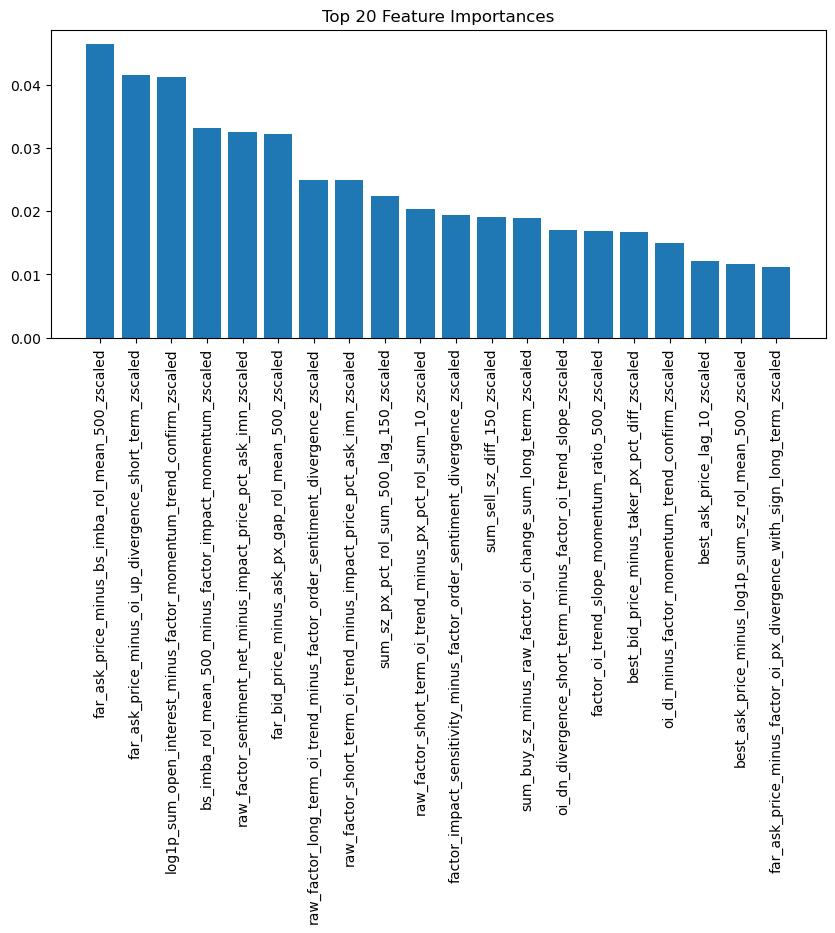

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 explain_matrix 是 TabNetClassifier 的解释矩阵 (n_samples, n_features)
mean_importance = np.mean(np.abs(explain_matrix), axis=0)
top_n = 20
top_indices = np.argsort(mean_importance)[::-1][:top_n]

# 特征名
top_feature_names = [X_train.columns[i] for i in top_indices]
top_importance_values = mean_importance[top_indices]

# 打印 Top N 特征名 + 权重
print(f"Top {top_n} Features by Importance:\n")
for name, score in zip(top_feature_names, top_importance_values):
    print(f"{name:<40} Importance: {score:.6f}")

# 画图
plt.figure(figsize=(10, 4))
plt.bar(range(top_n), top_importance_values)
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()


In [15]:
import numpy as np

mask_sample = masks[0][0]  # 第0步，第0个样本的mask
nonzero_indices = np.nonzero(mask_sample)[0]  # 找非零位置索引

print("被关注的特征索引:", nonzero_indices)
print("对应的权重:", mask_sample[nonzero_indices])

# 假设你的特征名列表是 feature_names（长度460）
for idx in nonzero_indices:
    print(f"特征: {X_train.columns[idx]}, 权重: {mask_sample[idx]:.4f}")


被关注的特征索引: [ 805  832 1044 1147 1240 1255 1297 1376 1847 1868 2632 2635 2763 2907]
对应的权重: [0.01767962 0.05728118 0.04143016 0.01868825 0.08083229 0.05579858
 0.06164651 0.06952362 0.09843068 0.17470877 0.06219988 0.16881363
 0.01569872 0.07726817]
特征: lob_sz_imba_rol_mean_500_second_order_diff_100_zscaled, 权重: 0.0177
特征: oi_px_diff_500_lag_200_zscaled, 权重: 0.0573
特征: taker_px_pct_diff_lag_5_zscaled, 权重: 0.0414
特征: factor_impact_momentum_second_order_diff_50_zscaled, 权重: 0.0187
特征: factor_oi_px_divergence_with_sign_long_term_lag_100_zscaled, 权重: 0.0808
特征: factor_oi_breakout_signal_diff_10_zscaled, 权重: 0.0558
特征: factor_order_sentiment_divergence_lag_5_zscaled, 权重: 0.0616
特征: sum_buy_sz_minus_impact_price_pct_ask_imn_zscaled, 权重: 0.0695
特征: raw_factor_long_term_oi_volatility_minus_lob_ratio_rol_mean_500_zscaled, 权重: 0.0984
特征: raw_factor_long_term_oi_volatility_minus_factor_px_oi_long_term_force_zscaled, 权重: 0.1747
特征: log1p_sum_open_interest_minus_oi_di_zscaled, 权重: 0.0622
特征: log1p_sum

In [16]:
import numpy as np
import pandas as pd

def show_tabnet_attention_masks(masks, feature_names, sample_idx=0, top_k=10):
    """
    显示 TabNet 对某个样本在每一步中关注的特征及其权重。

    参数:
    - masks: tabnet.explain(X)[1] 返回的字典
    - feature_names: list[str]，对应 X_train.columns
    - sample_idx: 选哪个样本
    - top_k: 最多展示前多少个非零特征
    """
    for step, mask_array in masks.items():
        mask_sample = mask_array[sample_idx]  # shape = (num_features,)
        nonzero_indices = np.nonzero(mask_sample)[0]
        weights = mask_sample[nonzero_indices]
        
        # 按照权重从高到低排序
        sorted_idx = np.argsort(-weights)
        top_indices = nonzero_indices[sorted_idx[:top_k]]
        
        print(f"\n🧭 Step {step}（共{len(nonzero_indices)}个非零特征）:")
        for i in top_indices:
            print(f"  特征: {feature_names[i]:<30} 权重: {mask_sample[i]:.4f}")


In [17]:
# 假设你已经有
# masks = tabnet.explain(X_test)[1]
# feature_names = list(X_test.columns)

show_tabnet_attention_masks(masks, X_train.columns, sample_idx=0, top_k=20)



🧭 Step 0（共14个非零特征）:
  特征: raw_factor_long_term_oi_volatility_minus_factor_px_oi_long_term_force_zscaled 权重: 0.1747
  特征: log1p_sum_open_interest_minus_taker_px_pct_diff_zscaled 权重: 0.1688
  特征: raw_factor_long_term_oi_volatility_minus_lob_ratio_rol_mean_500_zscaled 权重: 0.0984
  特征: factor_oi_px_divergence_with_sign_long_term_lag_100_zscaled 权重: 0.0808
  特征: oi_di_short_term_minus_factor_momentum_trend_confirm_zscaled 权重: 0.0773
  特征: sum_buy_sz_minus_impact_price_pct_ask_imn_zscaled 权重: 0.0695
  特征: log1p_sum_open_interest_minus_oi_di_zscaled 权重: 0.0622
  特征: factor_order_sentiment_divergence_lag_5_zscaled 权重: 0.0616
  特征: oi_px_diff_500_lag_200_zscaled 权重: 0.0573
  特征: factor_oi_breakout_signal_diff_10_zscaled 权重: 0.0558
  特征: taker_px_pct_diff_lag_5_zscaled 权重: 0.0414
  特征: factor_impact_momentum_second_order_diff_50_zscaled 权重: 0.0187
  特征: lob_sz_imba_rol_mean_500_second_order_diff_100_zscaled 权重: 0.0177
  特征: oi_up_divergence_minus_factor_orderflow_sz_momentum_zscaled 权重: 0.0157


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(masks, feature_names, sample_idx=0):
    """
    可视化 TabNet attention mask 热力图。
    """
    steps = sorted(masks.keys())
    mask_matrix = np.vstack([masks[step][sample_idx] for step in steps])

    plt.figure(figsize=(min(20, len(feature_names) * 0.3), len(steps)))
    sns.heatmap(mask_matrix, cmap="viridis", xticklabels=feature_names, yticklabels=[f"Step {s}" for s in steps])
    plt.title(f"TabNet Attention Heatmap for Sample {sample_idx}")
    plt.xlabel("Feature")
    plt.ylabel("Decision Step")
    plt.tight_layout()
    plt.show()


In [19]:
# plot_attention_heatmap(masks, X_train.columns, sample_idx=0)


In [20]:
# rolling_window_size = 50

# final_predictions_df = pd.concat(all_tabnet_test_predictions).sort_values('timestamp').reset_index(drop=True)

# final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

# tabnet_eval = evaluate_with_confidence(
#     y_true=final_predictions_df['true_label'],
#     y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
#     model_name="model",
#     lower_thresh=0.3,
#     upper_thresh=0.7,
#     print_report=True,
# )

# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['true_label'],      
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['px'],
#     std_array=final_predictions_df['rolling_std'],
#     n=1,
#     m=-1,
#     alpha=alpha,
# )
# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['true_label'], 
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['px'], 
#     std_array=final_predictions_df['rolling_std'], 
#     n=1,
#     m=-1, 
#     alpha=alpha
# )

# final_predictions_df

In [21]:
all_tab_inc_test_predictions

[          timestamp   symbol  true_label  predicted_value      px
 0     1751328342150  solusdt   -0.042664        -0.057133  154.43
 1     1751328553534  solusdt   -0.046763        -0.057086  154.75
 2     1751328984046  solusdt   -0.046735        -0.057214  155.06
 3     1751329023277  solusdt   -0.047543        -0.057306  155.50
 4     1751329071029  solusdt   -0.047509        -0.057013  155.18
 ...             ...      ...         ...              ...     ...
 9355  1754005525952  solusdt   -0.022903        -0.022237  172.24
 9356  1754005598753  solusdt   -0.022891        -0.017785  171.89
 9357  1754005720348  solusdt   -0.022903        -0.015561  172.24
 9358  1754005921268  solusdt   -0.022891        -0.015704  171.89
 9359  1754006118877  solusdt   -0.022903        -0.021482  172.24
 
 [9360 rows x 5 columns],
           timestamp   symbol  true_label  predicted_value      px
 0     1754006712209  solusdt   -0.017221        -0.023199  171.61
 1     1754006715937  solusdt   -0

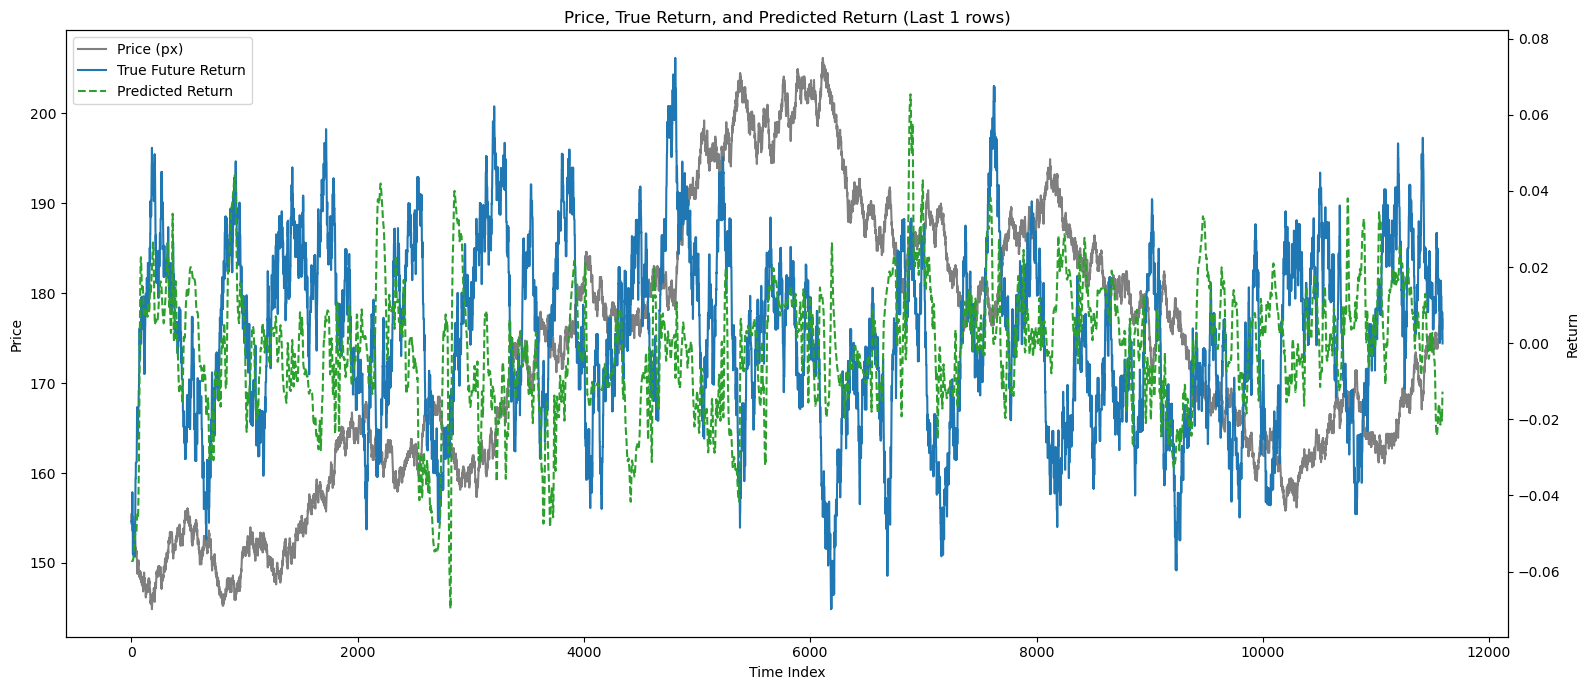

,timestamp,symbol,true_label,predicted_value,px,predicted_prob_rolling_mean,predicted_prob_rolling_mean_reverse
0,1751328342150,solusdt,-0.042664,-0.057133,154.43,-0.057133,1.057133
1,1751328553534,solusdt,-0.046763,-0.057086,154.75,-0.057110,1.057110
2,1751328984046,solusdt,-0.046735,-0.057214,155.06,-0.057144,1.057144
3,1751329023277,solusdt,-0.047543,-0.057306,155.50,-0.057185,1.057185
4,1751329071029,solusdt,-0.047509,-0.057013,155.18,-0.057151,1.057151
...,...,...,...,...,...,...,...
11587,1754650183049,solusdt,0.008151,-0.002630,175.95,-0.016947,1.016947
11588,1754650321617,solusdt,0.008134,0.007938,176.31,-0.013840,1.013840
11589,1754650444026,solusdt,0.004067,-0.016957,176.67,-0.013247,1.013247
11590,1754651451676,solusdt,-0.000056,-0.015889,177.03,-0.012720,1.012720


In [22]:
rolling_window_size = 10

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_value'].rolling(window=rolling_window_size, min_periods=1).mean()
final_predictions_df['predicted_prob_rolling_mean_reverse'] = 1-final_predictions_df['predicted_prob_rolling_mean']

plot_last_n_rows_with_px_regression(
    y_true=final_predictions_df['true_label'],
    y_pred=final_predictions_df['predicted_prob_rolling_mean'],
    px=final_predictions_df['px'],
    n=1,
    alpha=1.5
)

final_predictions_df

In [23]:
# 计算未来收益

final_predictions_df['future_return'] = (
    final_predictions_df['px'].shift(-future_window) / final_predictions_df['px'] - 1
)


from scipy.stats import spearmanr

signal_col = 'predicted_value'
return_col = 'future_return'
a
ic_df = final_predictions_df[[signal_col, return_col]].dropna()
rank_ic, p_value = spearmanr(ic_df[signal_col], ic_df[return_col])

print(f"Rank IC: {rank_ic:.4f}, p-value: {p_value:.4g}")


Rank IC: 0.0511, p-value: 4.428e-08


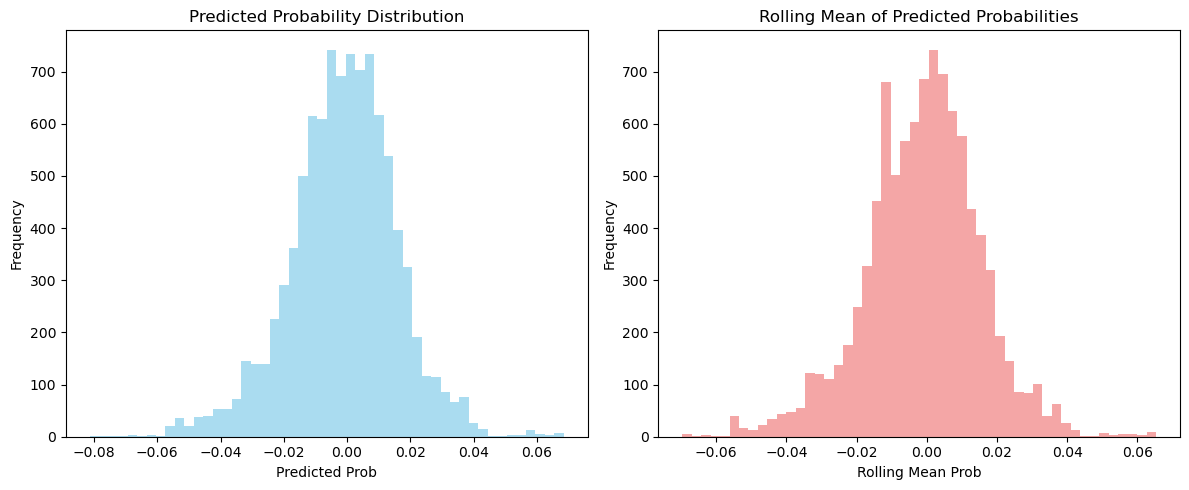

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 原始 predict_proba 分布
plt.subplot(1, 2, 1)
plt.hist(final_predictions_df['predicted_value'][2000:], bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

# 滚动均值分布
plt.subplot(1, 2, 2)
plt.hist(final_predictions_df['predicted_prob_rolling_mean'][2000:], bins=50, alpha=0.7, color='lightcoral')
plt.title('Rolling Mean of Predicted Probabilities')
plt.xlabel('Rolling Mean Prob')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


2025-07-01 00:05:42.150000: SELL_SHORT_OPEN -582.91 @ 154.32 (Prob: -0.0571) | Capital: 100000.00
2025-07-01 07:20:27.151000: BUY_TO_COVER_SHORT 582.91 @ 149.80 | PnL: 2589.38 | Capital: 102589.38 | Reason: Short Take Profit Hit
2025-07-01 07:21:56.811000: SELL_SHORT_OPEN -618.13 @ 149.30 (Prob: -0.0454) | Capital: 102589.38
2025-07-01 20:01:19.797000: BUY_TO_COVER_SHORT 618.13 @ 144.97 | PnL: 2628.00 | Capital: 105217.39 | Reason: Short Take Profit Hit
2025-07-14 07:53:53.235000: SELL_SHORT_OPEN -565.33 @ 167.42 (Prob: -0.0455) | Capital: 105217.39
2025-07-14 19:26:09.852000: BUY_TO_COVER_SHORT 565.33 @ 163.66 | PnL: 2078.37 | Capital: 107295.75 | Reason: 
2025-07-14 19:34:40.997000: SELL_SHORT_OPEN -589.30 @ 163.79 (Prob: -0.0558) | Capital: 107295.75
2025-07-15 03:10:30.205000: BUY_TO_COVER_SHORT 589.30 @ 158.91 | PnL: 2825.47 | Capital: 110121.22 | Reason: Short Take Profit Hit
2025-07-17 10:57:27.813000: SELL_SHORT_OPEN -560.84 @ 176.63 (Prob: -0.0451) | Capital: 110121.22
2025-07

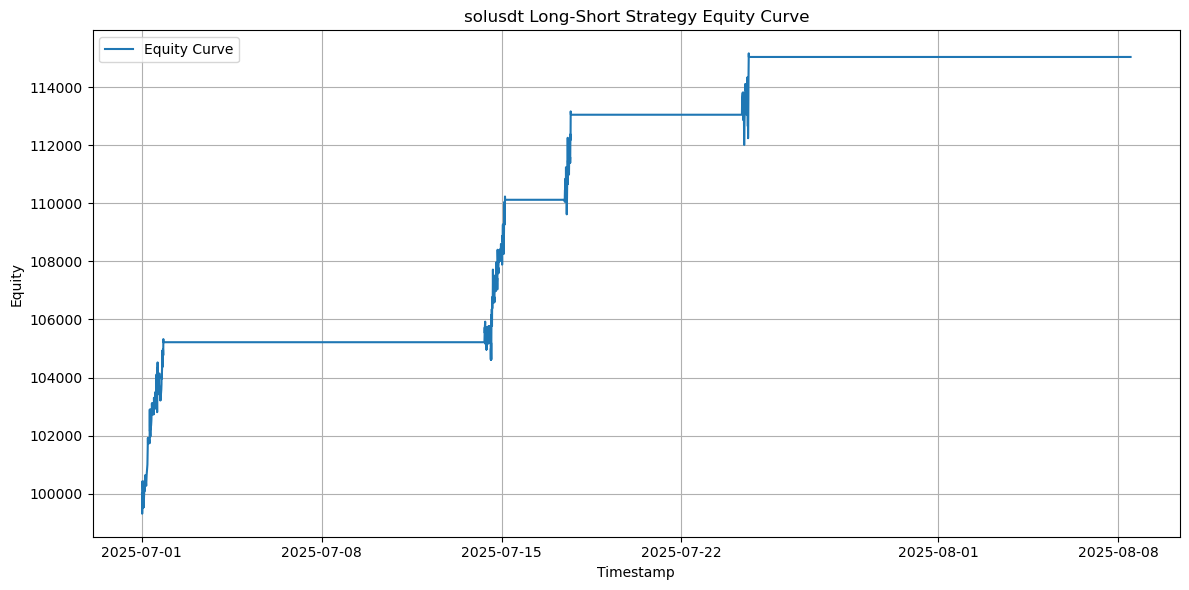

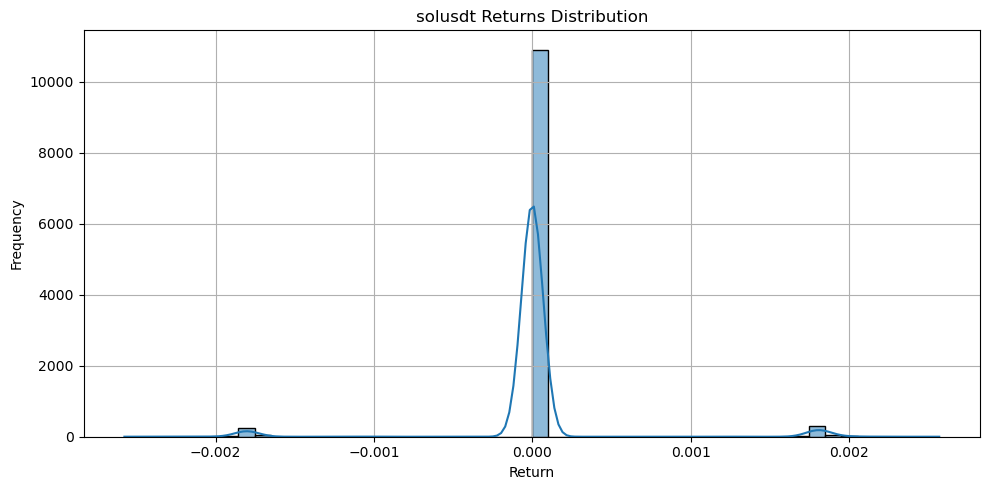

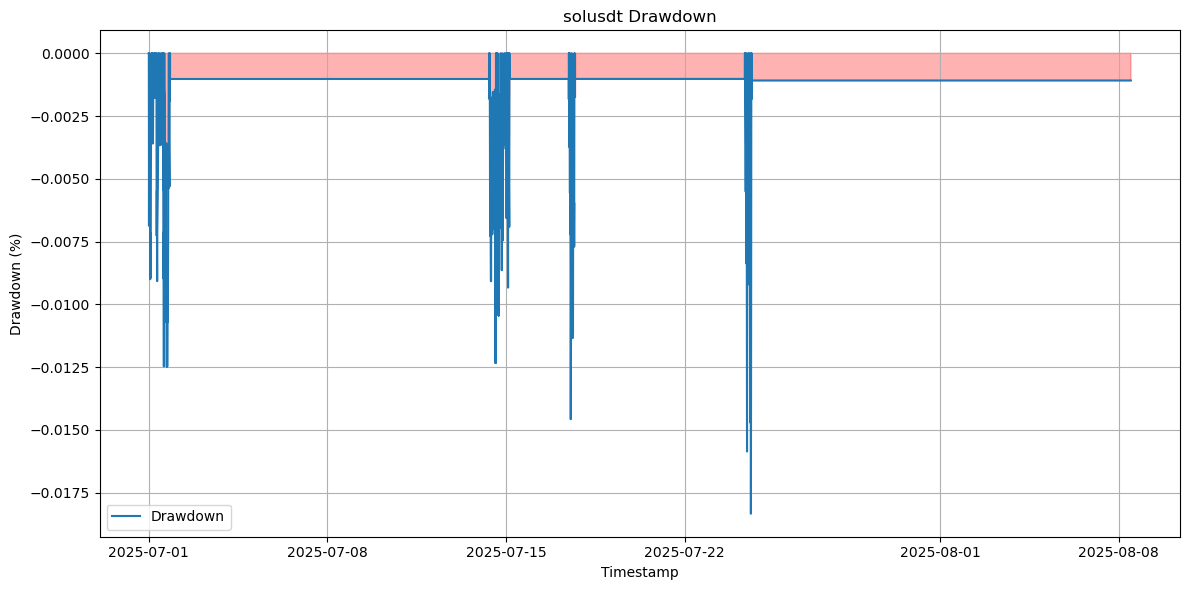

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

ma_window = int(feat_norm_rolling_mean_window)
# ma_window = 200

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds
all_predictions_df['ma'] = all_predictions_df['px'].rolling(window=ma_window).mean()

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.0007   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.045 # Predicted probability above this to go long (buy)
short_threshold = -0.045  # Predicted probability below this to go short (sell)

beta = 3
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

step = 0

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    ma = df['ma'].iloc[i]
    current_rolling_std = current_px * 0.01
    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        step += 1
        
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close or step > future_window:
            step = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")
            
            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        step += 1

        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close or step > future_window:
            step = 0

            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_value'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_value'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)
print("ma")

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [26]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


In [95]:

print(len(feature_cols))
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

overall_start = None
overall_end = None


train_dfs = weekly_dataframes[-n_train_weeks:]

train_df = pl.concat(train_dfs)

train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
X_train = train_df_processed[feature_cols]
y_train = train_df_processed[target_col]
px_train = train_df_processed['px']


tabnet = TabNetRegressor(**params)
tabnet.fit(
    X_train=X_train.values, 
    y_train=y_train.values.reshape(-1, 1),
    **init_fit_params,
)


3002


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.25206 |  0:00:01s
epoch 20 | loss: 0.00065 |  0:00:23s
epoch 40 | loss: 0.0004  |  0:00:45s
epoch 60 | loss: 0.00031 |  0:01:06s
epoch 80 | loss: 0.00026 |  0:01:28s
epoch 100| loss: 0.00022 |  0:01:50s
epoch 120| loss: 0.0002  |  0:02:11s
epoch 140| loss: 0.00017 |  0:02:33s
epoch 160| loss: 0.00016 |  0:02:55s
epoch 180| loss: 0.00014 |  0:03:17s


In [96]:
save_tabnet_checkpoint(
    model=tabnet,
    symbol=symbol,
    base_save_dir="./saved_models/tabnet_inc_regressor",
    model_params=params,
    feature_names=X_train.columns,
    training_meta={
        "symbol": symbol,
        "train_target": file,
        "train_n_week": n_train_weeks,
        "init_fit_params": init_fit_params,
        "label_window": future_window,
        "fit_start_date": overall_start,
        "fit_end_date": overall_end,
        "saved_timestamp": str(pd.Timestamp.now()),
        "feat_cal_window": int(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_trans_lags": feat_trans_lags,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
        "bt_up_thresh": long_threshold,
        "bt_dn_thresh": short_threshold,
        "bt_beta": beta,
        "bt_ret": total_return,
        "bt_dd": max_drawdown,
        "bt_n_trade": len(trades),
    },
)

Successfully saved model at ./saved_models/tabnet_inc_regressor\solusdt_2025-08-18_02-07\tabnet_model.zip
model and meta info saved to ./saved_models/tabnet_inc_regressor\solusdt_2025-08-18_02-07


In [29]:
# all_df_processed = a_df_filtered.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
# X_all = all_df_processed[feature_cols]
# y_all = all_df_processed[target_col]
# px_all = all_df_processed['px']
# std_all = all_df_processed['rolling_std']
# timestamps_all = all_df_processed['timestamp'] # 收集时间戳

# a = tab_inc.predict_proba(X_train.values)[:, 1]
# print(a)
# all_tab_inc_test_verify = []
# current_window_results = pd.DataFrame({
#     'timestamp': timestamps_all,
#     'symbol': "tst", # 如果有多个股票，收集 symbol 是必要的
#     'true_label': y_all,
#     'predicted_prob': tab_inc.predict_proba(X_all.values)[:, 1],
#     'px': px_all, # 收集价格，回测时需要
#     'rolling_std': std_all # 收集波动率，可能用于策略或分析
#     # 添加任何你回测需要的其他数据
# })
# all_tab_inc_test_verify.append(current_window_results)


In [30]:
# rolling_window_size = 10

# final_predictions_df = pd.concat(all_tab_inc_test_verify).sort_values('timestamp').reset_index(drop=True)

# final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

# tabnet_eval = evaluate_with_confidence(
#     y_true=final_predictions_df['true_label'],
#     y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
#     model_name="model",
#     lower_thresh=0.05,
#     upper_thresh=0.95,
#     print_report=True,
# )

# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['true_label'],      
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['px'],
#     std_array=final_predictions_df['rolling_std'],
#     n=1,
#     m=-1,
#     alpha=alpha,
# )
# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['true_label'], 
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['px'], 
#     std_array=final_predictions_df['rolling_std'], 
#     n=1,
#     m=-1, 
#     alpha=alpha
# )

# final_predictions_df